In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan
from collections import Counter

In [2]:
k_neighbors = 100
evecs=50

In [13]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

# D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
# D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))

L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

L_evals = pickle.load(open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs = pickle.load(open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals = pickle.load(open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs = pickle.load(open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "rb"))

L_evals_svd = pickle.load(open("./data/L_evals_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_evecs_svd = pickle.load(open("./data/L_evecs_svd{}_K{}.p".format(evecs, k_neighbors), 'rb'))

L_mc_evals_svd = pickle.load(open("./data/L_mc_evals_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))
L_mc_evecs_svd = pickle.load(open("./data/L_mc_evecs_svd{}_K{}.p".format(evecs, k_neighbors), "rb"))

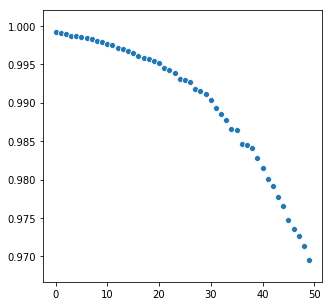

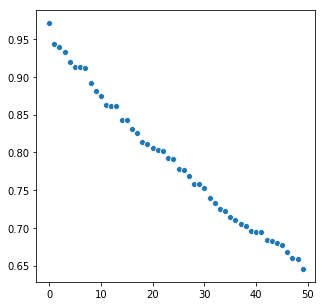

In [15]:
#print(np.flip(L_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals_svd.shape[0]), L_evals_svd)

#print(np.flip(L_mc_evals_svd))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_mc_evals_svd.shape[0]), L_mc_evals_svd)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.97118373 0.94371433 0.94009284 0.93328925 0.9199374  0.91387979
 0.91318435 0.91154159 0.89257133 0.88177404 0.87531611 0.86283667
 0.86153864 0.86119952 0.84363323 0.84341346 0.83112448 0.82633777
 0.81335631 0.8114     0.80624134 0.80300523 0.80166364 0.79229675
 0.79143375 0.77862952 0.7774387  0.76892759 0.75890147 0.75821493
 0.75340726 0.73955806 0.73422813 0.72579029 0.72346486 0.71658562
 0.71182571 0.70513435 0.7030482  0.69710302 0.69685017 0.6954559
 0.6866919  0.68653531 0.68416189 0.67923224 0.67742365 0.6711551
 0.66220776 0.65722758]


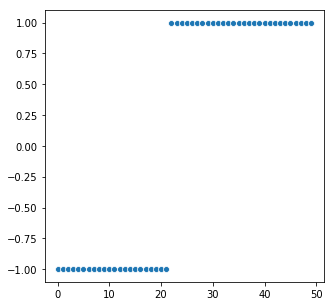

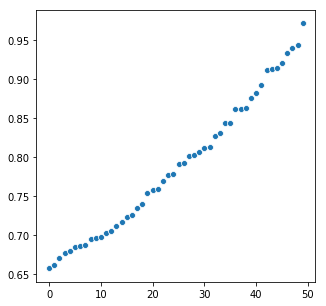

In [4]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [21]:
def get_evec_df(evecs, top_k_evecs=5):
    k_evecs = evecs[:, -top_k_evecs:]
    evec_cols = ["Evec_{}".format(i) for i in range(top_k_evecs)]
    evec_df = pd.DataFrame(k_evecs, columns=evec_cols)
    return evec_df

describe_topk = 5
L_evecdf = get_evec_df(L_evecs, top_k_evecs=describe_topk)
L_mc_evecdf = get_evec_df(L_mc_evecs, top_k_evecs=describe_topk)

L_svd_evecdf = get_evec_df(L_evecs_svd, top_k_evecs=describe_topk)
L_mc_svd_evecdf = get_evec_df(L_mc_evecs_svd, top_k_evecs=describe_topk)

In [22]:
print(L_evecdf.describe())
print(L_mc_evecdf.describe())

print(L_svd_evecdf.describe())
print(L_mc_svd_evecdf.describe())

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4
count  44083.000000  44083.000000  44083.000000  44083.000000  44083.000000
mean       0.000365      0.000748      0.000034      0.000647      0.001186
std        0.004749      0.004704      0.004763      0.004719      0.004613
min       -0.340136     -0.383533     -0.369778     -0.186798     -0.517620
25%        0.000215      0.000447      0.000017      0.000381      0.000700
50%        0.000312      0.000648      0.000024      0.000553      0.001016
75%        0.000430      0.000892      0.000034      0.000761      0.001398
max        0.359752      0.286814      0.335390      0.287999      0.197009
             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4
count  4.408300e+04  4.408300e+04  4.408300e+04  4.408300e+04  4.408300e+04
mean   1.451141e-04  3.204272e-04  1.713936e-04  1.859389e-04 -1.984674e-04
std    4.760666e-03  4.752086e-03  4.759792e-03  4.759246e-03  4.758740e-03
min   -4.820

In [35]:
def get_Y(evecs, drop_k_evecs = 1, keep_top_k_evecs = 5):
    X_top_k = evecs[:, -drop_k_evecs-keep_top_k_evecs:-drop_k_evecs]
    evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
    Y_top_k = X_top_k / evecs_lengths_top_k[:, None]
    return Y_top_k

keep_k_evecs=5
drop_k_evecs=1
# Y = get_Y(L_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
# Y_mc = get_Y(L_mc_evecs, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

Y = get_Y(L_evecs_svd, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)
Y_mc = get_Y(L_mc_evecs_svd, drop_k_evecs=drop_k_evecs, keep_top_k_evecs=keep_k_evecs)

print(Y.shape, Y_mc.shape)

(44083, 5) (44083, 5)


In [28]:
visualizer = Visualizer()
lc=100

try:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

    Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
    Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
except FileNotFoundError:
    print("Error: 1 or more umap files not found")
    Y_umap_2d = visualizer.umap_embedding(Y, n_components=2, lc=lc)
    Y_umap_3d = visualizer.umap_embedding(Y, n_components=3, lc=lc)
    
    Y_mc_umap_2d = visualizer.umap_embedding(Y_mc, n_components=2, lc=lc)
    Y_mc_umap_3d = visualizer.umap_embedding(Y_mc, n_components=3, lc=lc)

    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

    pickle.dump(Y_mc_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))
    pickle.dump(Y_mc_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'wb'))

Error: 1 or more umap files not found


./../../src/visualizer_helper.py:22: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  return UMAP(n_components=n_components, local_connectivity=lc).fit_transform(X)


running Kmeans
Cluster labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


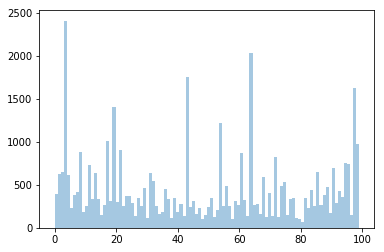

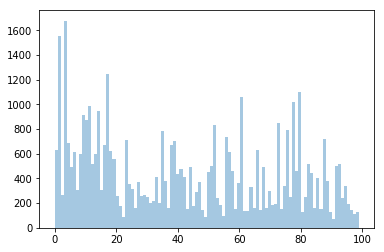

In [36]:
knn_clusters = 100

try:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
    Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
except FileNotFoundError:
    print("running Kmeans")
    
    Y_kmeans = KMeans(n_clusters=knn_clusters).fit(Y)
    Y_mc_kmeans = KMeans(n_clusters=knn_clusters).fit(Y_mc)

    Y_cluster_labels = Y_kmeans.labels_    
    Y_mc_cluster_labels = Y_mc_kmeans.labels_

    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))
    pickle.dump(Y_mc_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), "wb"))

    print("Cluster labels:", np.unique(Y_cluster_labels))
    
plt.figure()
sns.distplot(Y_cluster_labels, bins=knn_clusters, kde=False)
plt.figure()
sns.distplot(Y_mc_cluster_labels, bins=knn_clusters, kde=False)

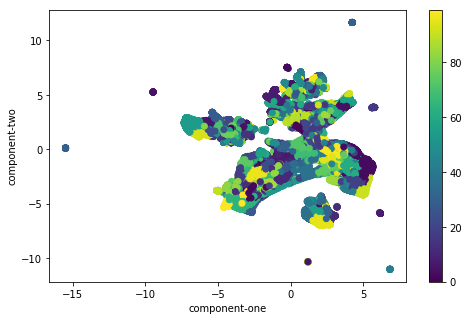

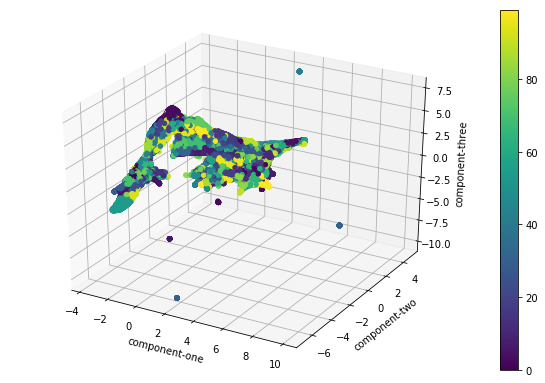

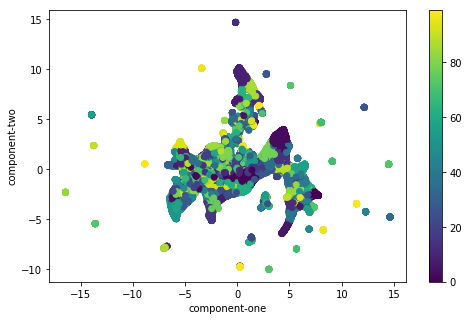

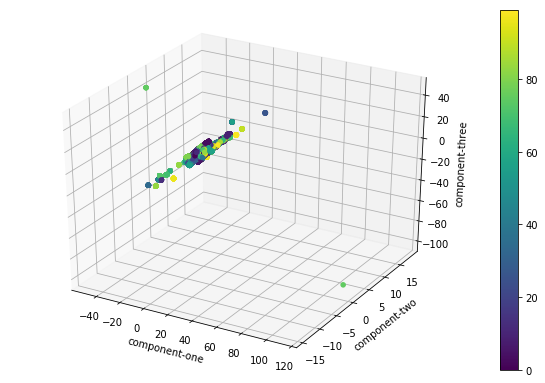

In [37]:
alpha = 1

filename_2d = "./figures/umap2d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_3d = "./figures/umap3d_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)   

filename_mc_2d = "./figures/umap2d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)
filename_mc_3d = "./figures/umap3d_mc_K{}_topkevecs{}_knn{}".format(k_neighbors, keep_k_evecs, knn_clusters)

visualizer.plot2d(
    X=Y_umap_2d, 
    filename=filename_2d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename=filename_3d, 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot2d(
    X=Y_mc_umap_2d, 
    filename=filename_mc_2d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)
visualizer.plot3d(
    X=Y_mc_umap_3d, 
    filename=filename_mc_3d, 
    colors=Y_mc_cluster_labels,
    alpha = alpha
)

#PLOT CENTROIDS FOR K MEANS
#PLOT SOME MEMBERS FROM EACH CENTROID


In [33]:
def sort_by_cluster_membership(M, cluster_labels):
    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    clusters_by_idx = [p[0] for p in sorted_cluster_labels]
    return M[clusters_by_idx][:, clusters_by_idx]

def sort_by_top_k_cluster_membership(M, k, cluster_labels, exclude=2):    
    
    top_cluster_and_counts = Counter(cluster_labels).most_common(k + exclude)
    print(top_cluster_and_counts)
    top_cluster_and_counts = top_cluster_and_counts[exclude:]
    print("...".format(exclude), top_cluster_and_counts)
    most_common_clusters = [c[0] for c in top_cluster_and_counts]

    sorted_cluster_labels = sorted(list(enumerate(cluster_labels.tolist())), key=lambda p: p[1])
    
    sorted_cluster_labels_filtered = [p for p in sorted_cluster_labels if p[1] in most_common_clusters]
    clusters_by_idx = [p[0] for p in sorted_cluster_labels_filtered]
    return M[clusters_by_idx][:, clusters_by_idx]
    
L_sorted = sort_by_cluster_membership(L, Y_cluster_labels)
L_mc_sorted = sort_by_cluster_membership(L_mc, Y_mc_cluster_labels)

A_sorted = sort_by_cluster_membership(A, Y_cluster_labels)
A_mc_sorted = sort_by_cluster_membership(A, Y_mc_cluster_labels)

topk_clusters = 3
exclude_topk = 0
A_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_cluster_labels, exclude_topk)
L_sorted_topk = sort_by_top_k_cluster_membership(L, topk_clusters, Y_cluster_labels, exclude_topk)

A_mc_sorted_topk = sort_by_top_k_cluster_membership(A, topk_clusters, Y_mc_cluster_labels, exclude_topk)
L_mc_sorted_topk = sort_by_top_k_cluster_membership(L_mc, topk_clusters, Y_mc_cluster_labels, exclude_topk)

print(L_sorted.shape, A_sorted.shape, L_mc_sorted.shape, A_mc_sorted.shape)
print(L_sorted_topk.shape, A_sorted_topk.shape, L_mc_sorted_topk.shape, A_mc_sorted_topk.shape)

[(2, 4094), (31, 2950), (3, 2003)]
... [(2, 4094), (31, 2950), (3, 2003)]
[(2, 4094), (31, 2950), (3, 2003)]
... [(2, 4094), (31, 2950), (3, 2003)]
[(12, 2701), (25, 2628), (9, 2063)]
... [(12, 2701), (25, 2628), (9, 2063)]
[(12, 2701), (25, 2628), (9, 2063)]
... [(12, 2701), (25, 2628), (9, 2063)]
(44083, 44083) (44083, 44083) (44083, 44083) (44083, 44083)
(9047, 9047) (9047, 9047) (7392, 7392) (7392, 7392)


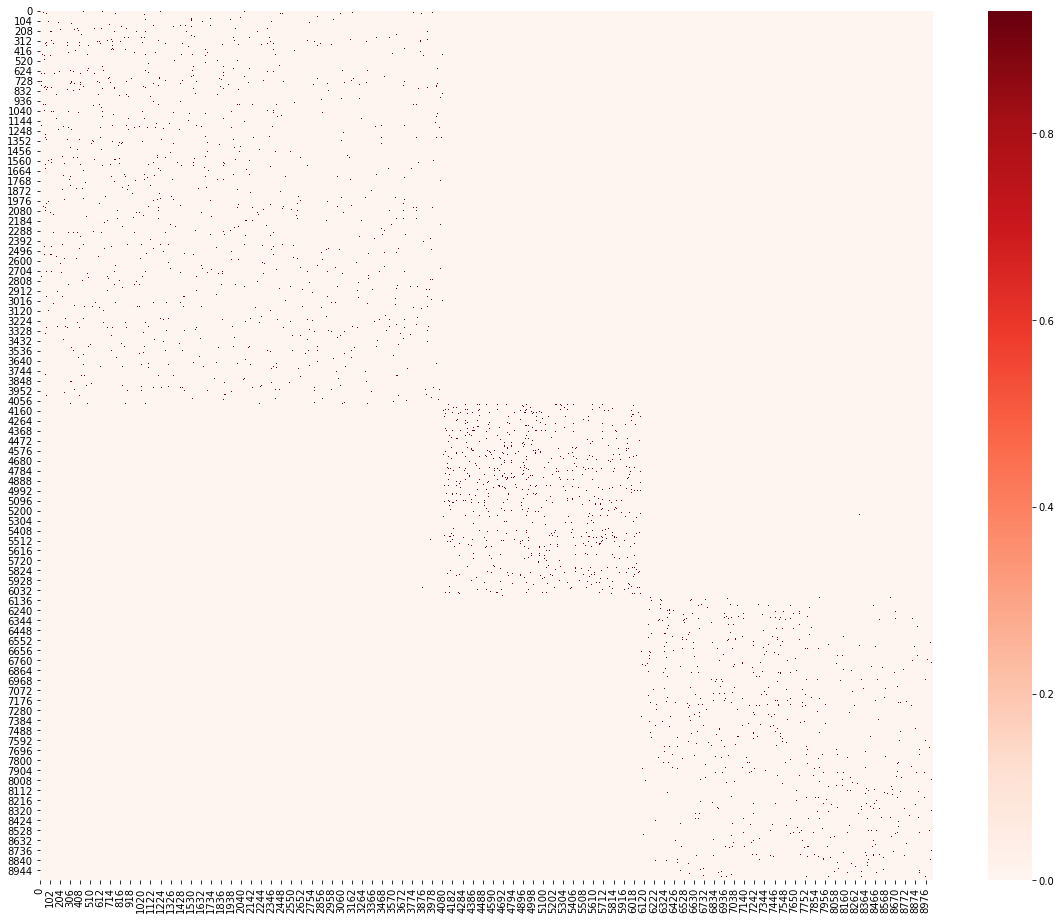

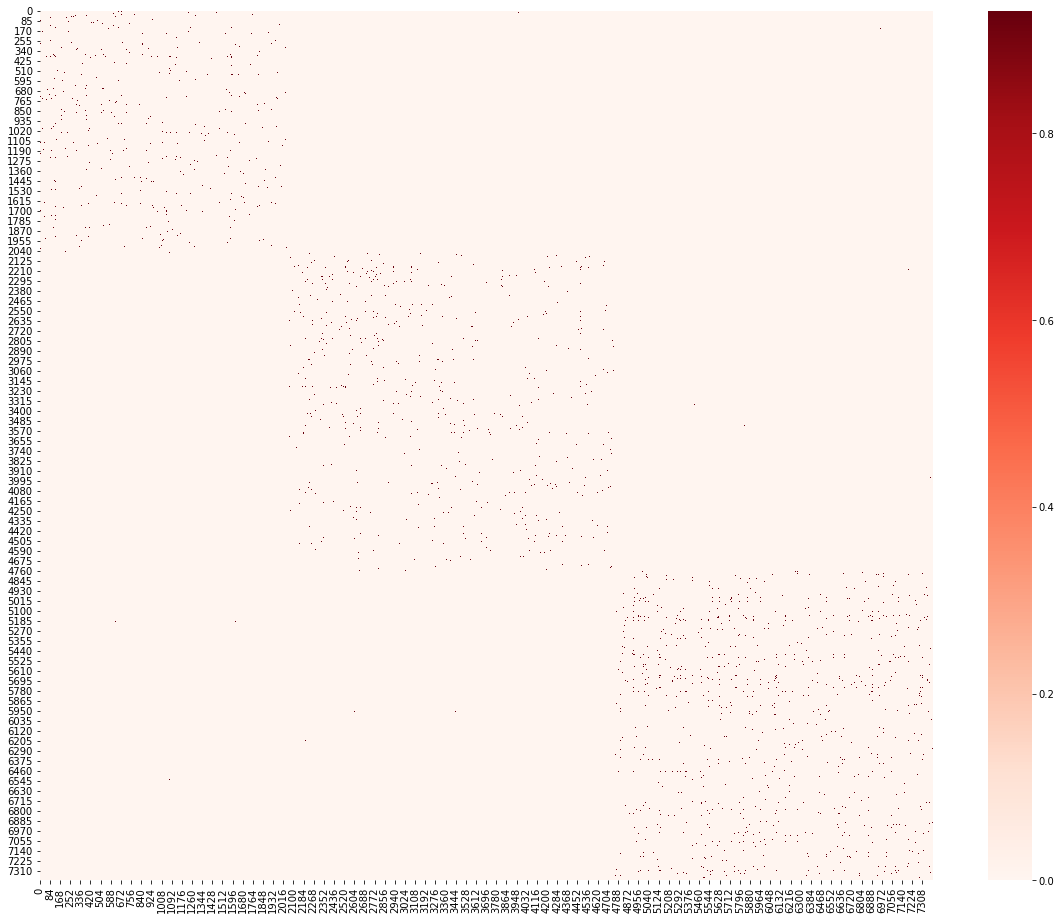

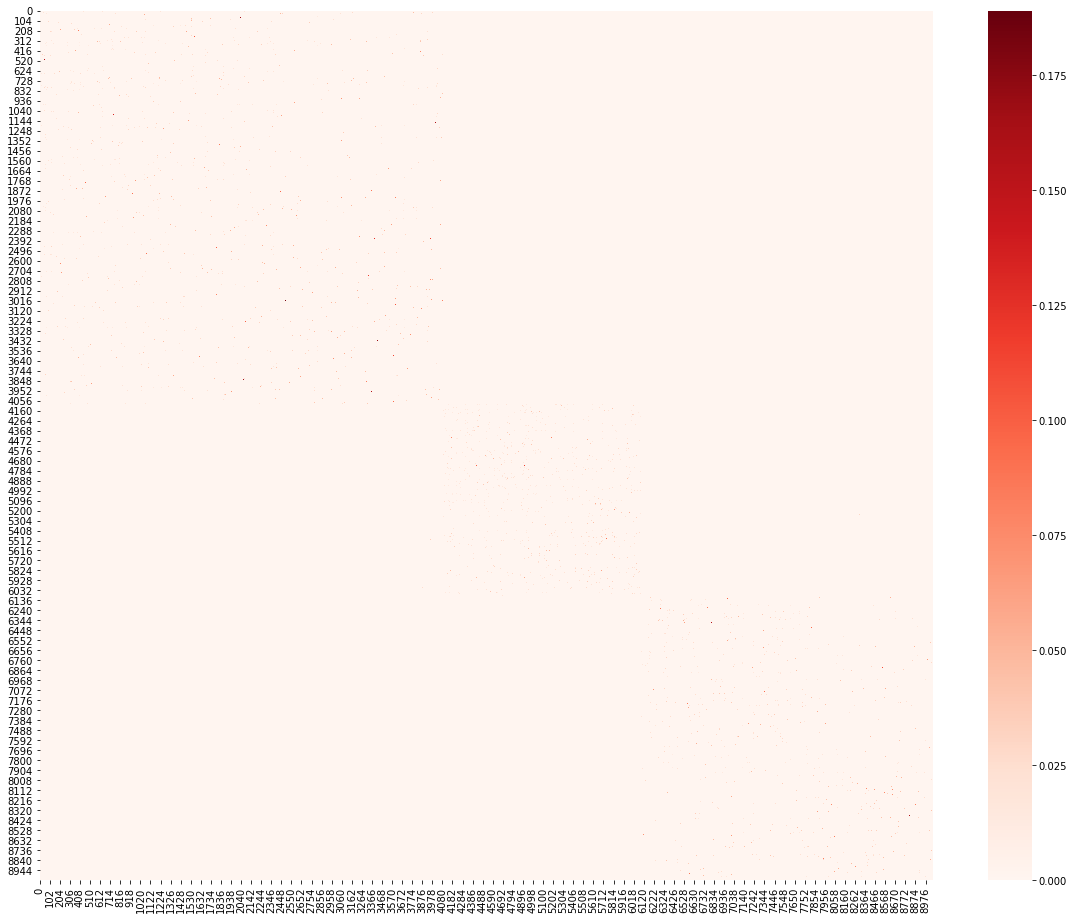

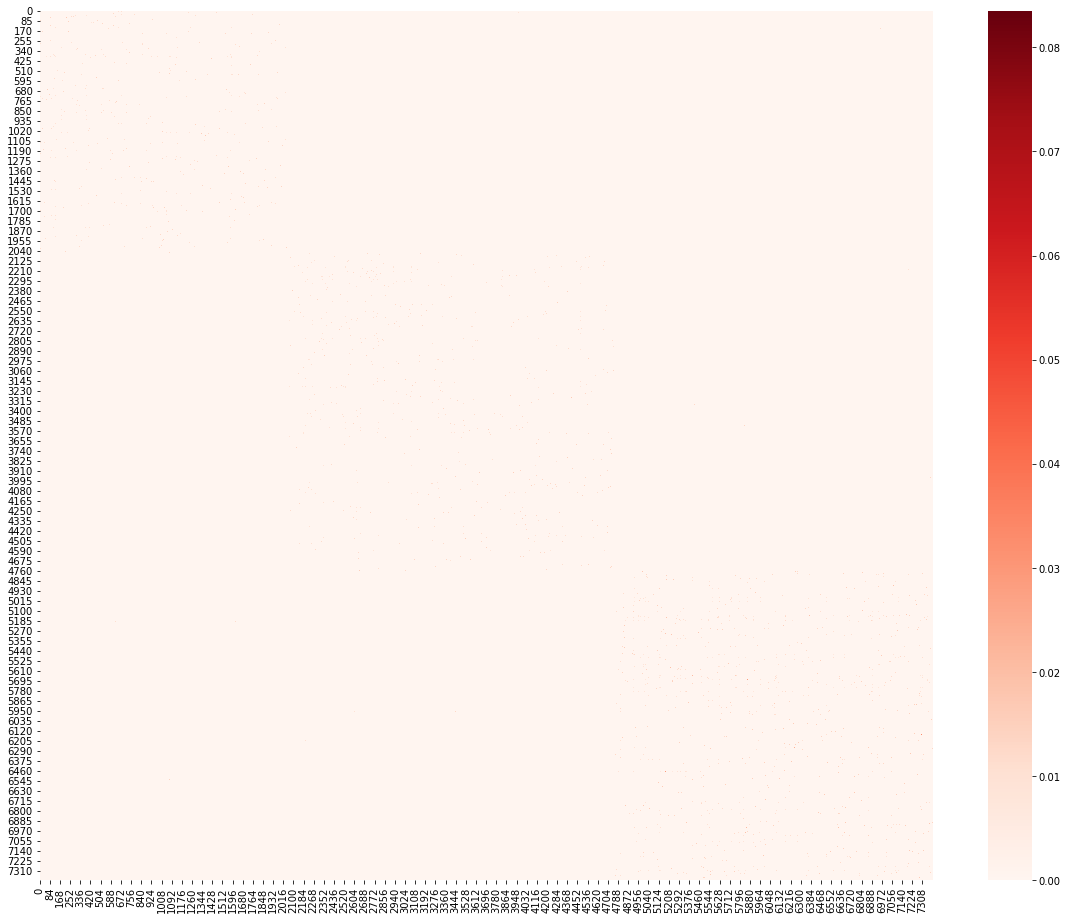

In [34]:
##Full Heatmaps
plot_vars = [A_sorted_topk, A_mc_sorted_topk, L_sorted_topk, L_mc_sorted_topk]
plot_var_names = ['A_sorted_topk', 'A_mc_sorted_topk', 'L_sorted_topk', 'L_mc_sorted_topk']
for v in range(len(plot_vars)):
    var = plot_vars[v]
    varname = plot_var_names[v]

    plotmax = var.log1p().log1p().max()/2.0
    plt.figure(figsize=(20,16))
    sns.heatmap(var.log1p().log1p().toarray(), cmap="Reds", vmax=plotmax)
    plt.savefig("./figures/heatmap_{}_K{}_knn{}_kevecs{}.png".format(varname, k_neighbors, knn_clusters, keep_k_evecs))